## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [1]:
# # Mounting google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-04-15 12:07:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-15 12:07:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-15 12:07:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
!pip install tensorflow

In [4]:
pip install pandas

ERROR: Could not find a version that satisfies the requirement pandas (from versions: none)
ERROR: No matching distribution found for pandas
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

2024-04-15 12:20:35.272350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 12:20:35.272456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 12:20:35.309576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 12:20:35.387009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 12:20:36.659407: W tensorflow/compiler/tf2

In [10]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [12]:
from keras.preprocessing.sequence import pad_sequences

## Loading dataset

In [13]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("IMDB Dataset.csv")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [14]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [15]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [16]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

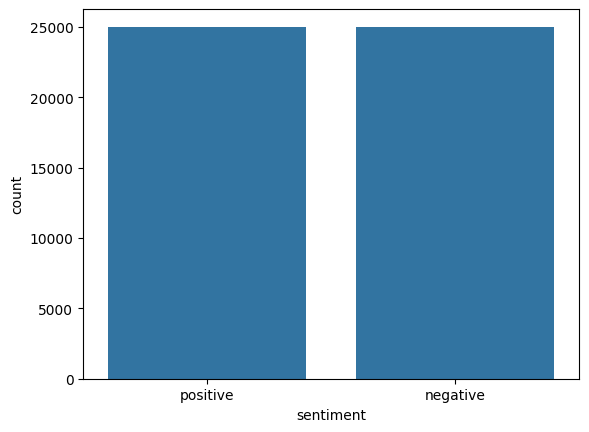

In [18]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [19]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

'best days life '

In [20]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
!unzip glove*.zip

/bin/bash: line 1: unzip: command not found


In [24]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [26]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [27]:
# Sample cleaned up movie review 

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [28]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [30]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [31]:
import io
import json

In [32]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [33]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [34]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [36]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [37]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [38]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Recurrent Neural Network (LSTM)

In [39]:
from keras.layers import LSTM

In [40]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

2024-04-15 12:25:51.007006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 12:25:51.160019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 12:25:51.160092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 12:25:51.161811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 12:25:51.161872: I external/local_xla/xla/stream_executor

In [41]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [42]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10


2024-04-15 12:26:09.006472: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12800000 exceeds 10% of free system memory.
2024-04-15 12:26:10.372727: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/250 [..............................] - ETA: 7:59 - loss: 0.6955 - acc: 0.5312

2024-04-15 12:26:10.812025: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f593b348c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 12:26:10.812071: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-04-15 12:26:10.823202: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713164170.912243   12381 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 6s 15ms/step - loss: 0.5229 - acc: 0.7473 - val_loss: 0.4382 - val_acc: 0.7986
Epoch 2/10
250/250 [==============================] - 3s 13ms/step - loss: 0.4271 - acc: 0.8078 - val_loss: 0.4240 - val_acc: 0.8111
Epoch 3/10
250/250 [==============================] - 3s 13ms/step - loss: 0.3812 - acc: 0.8325 - val_loss: 0.3625 - val_acc: 0.8413
Epoch 4/10
250/250 [==============================] - 3s 13ms/step - loss: 0.3485 - acc: 0.8520 - val_loss: 0.3356 - val_acc: 0.8580
Epoch 5/10
250/250 [==============================] - 3s 12ms/step - loss: 0.3290 - acc: 0.8619 - val_loss: 0.3426 - val_acc: 0.8537
Epoch 6/10
250/250 [==============================] - 3s 13ms/step - loss: 0.3143 - acc: 0.8716 - val_loss: 0.3340 - val_acc: 0.8644
Epoch 7/10
250/250 [==============================] - 3s 12ms/step - loss: 0.2923 - acc: 0.8790 - val_loss: 0.3672 - val_acc: 0.8535
Epoch 8/10
250/250 [==============================] - 4s 14ms/step - loss: 0.269

In [43]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 7ms/step - loss: 0.3553 - acc: 0.8633


In [44]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3553224205970764
Test Accuracy: 0.8633000254631042


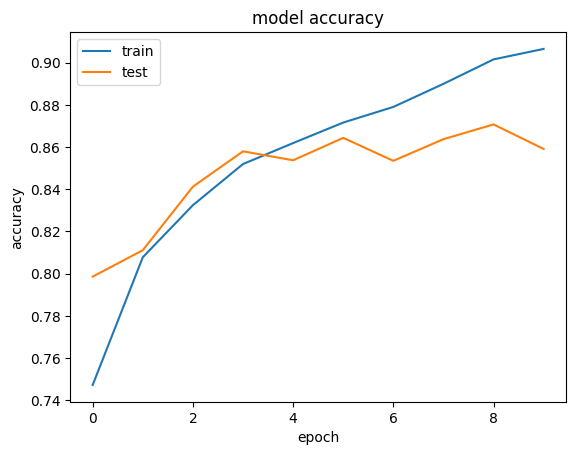

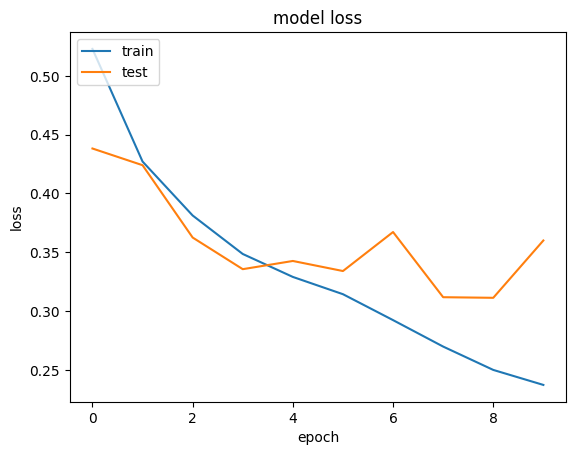

In [45]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [46]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/root/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-04-15 12:27:41.472832: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36957600 exceeds 10% of free system memory.


# Making Predictions on Live IMDb data

In [2]:
pwd # lists files in working directory

'C:\\Users\\Gopal\\OneDrive\\Desktop\\Skillcate\\Projects\\movie-sentiment-analysis-with-deep-neural-networks'

In [48]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='c1_lstm_model_acc_0.863.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________


2024-04-15 12:38:01.442219: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36957600 exceeds 10% of free system memory.


In [7]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [11]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = custom.preprocess_text(review)
  unseen_processed.append(review)

In [12]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [13]:
from keras_preprocessing.text import tokenizer_from_json

In [16]:
# Loading
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [17]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [18]:
unseen_tokenized

[[925,
  1,
  1,
  400,
  14420,
  1289,
  627,
  14035,
  1266,
  7357,
  511,
  1524,
  97,
  1863,
  1370,
  1,
  3416,
  16,
  4,
  25,
  140,
  20211,
  716,
  2161,
  1270,
  14035,
  18,
  12177,
  199,
  659,
  9047,
  76,
  9587,
  1378,
  4780,
  1464,
  6932,
  4780,
  2013,
  7929,
  7741,
  1034,
  33,
  83,
  463,
  435,
  879,
  1740,
  282,
  1469,
  150,
  626,
  3,
  1434,
  1291,
  3,
  62,
  1,
  806,
  4114,
  5415,
  1989,
  191,
  806,
  51,
  854,
  13,
  88,
  11,
  16,
  4012,
  1,
  589,
  1958,
  1398,
  93,
  113,
  1014,
  24,
  270,
  1,
  2759,
  62,
  1014,
  1,
  14035,
  25602,
  25,
  315,
  1064,
  115,
  1852,
  736,
  1,
  14035,
  1776,
  1,
  315,
  3822,
  18,
  383,
  3822,
  569,
  1,
  4051,
  24,
  284,
  164,
  624,
  14035,
  261,
  1,
  12806,
  83,
  5440,
  294,
  1776,
  1,
  1011,
  213,
  278,
  1374,
  1040,
  14943,
  3822,
  897,
  17,
  151,
  312,
  1264,
  1,
  1928,
  285,
  1602,
  14420,
  1,
  3172,
  1,
  122,
  659,
  14

In [21]:
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [22]:
unseen_padded

array([[  879,  1740,   282,  1469,   150,   626,     3,  1434,  1291,
            3,    62,     1,   806,  4114,  5415,  1989,   191,   806,
           51,   854,    13,    88,    11,    16,  4012,     1,   589,
         1958,  1398,    93,   113,  1014,    24,   270,     1,  2759,
           62,  1014,     1, 14035, 25602,    25,   315,  1064,   115,
         1852,   736,     1, 14035,  1776,     1,   315,  3822,    18,
          383,  3822,   569,     1,  4051,    24,   284,   164,   624,
        14035,   261,     1, 12806,    83,  5440,   294,  1776,     1,
         1011,   213,   278,  1374,  1040, 14943,  3822,   897,    17,
          151,   312,  1264,     1,  1928,   285,  1602, 14420,     1,
         3172,     1,   122,   659,   140, 13082,  1645, 10209,  1615,
          937],
       [  121,   234,   352,  8844,  6752,   630,    20,  6507,    72,
         1400,  6730,  2885, 24074, 10547,  3633,  1645,    25, 11701,
         1335, 19425,    26,   281,  1574,  1143,   288, 1370

In [23]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 1s/step


array([[0.8834934 ],
       [0.99290115],
       [0.31473464],
       [0.27548054],
       [0.97470117],
       [0.04180601]], dtype=float32)

In [24]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,3.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.4


In [25]:
unseen_sentiments

array([[0.8834934 ],
       [0.99290115],
       [0.31473464],
       [0.27548054],
       [0.97470117],
       [0.04180601]], dtype=float32)

In [28]:
unseen_sentiments[0][0]

0.8834934

In [41]:
prediction_text= f"Positive Review with probable IMDb rating as: {np.round(unseen_sentiments[0][0]*10,1)}"

In [42]:
prediction_text

'Positive Review with probable IMDb rating as: 8.8'